In [14]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from scipy import stats
import scipy
from scipy.interpolate import make_interp_spline, BSpline
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

%matplotlib inline
from IPython.display import Image, display

In [2]:
## import subset SB AR MERRA2 file
# SBfilename = '/home/sbarc/students/nash/data/MERRA-2/SB_AR_vertical_vapor_flux.nc'
SBfilename = '/home/sbarc/students/nash/data/MERRA-2/SB_march_AR_vertical_vapor_flux.nc'
ds_merra = xr.open_dataset(SBfilename)
MERRA_flux = np.sqrt((ds_merra.U*ds_merra.QV)**2 + (ds_merra.V*ds_merra.QV)**2)

data_plot = []
for i in MERRA_flux.lev.values:
    data_plot.append(MERRA_flux.sel(lev=i).values)
    
merra_mean = MERRA_flux.mean('time')

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
g = -9.81 # gravity constant
u = ds_merra.U[:,3:].squeeze()
v = ds_merra.V[:,3:].squeeze()
q = ds_merra.QV[:,3:].squeeze()
p = ds_merra.lev.values[3:].squeeze()
ivt_u = scipy.integrate.trapz(u*q, p, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(v*q, p, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)
# ivt_total = ivt_total.squeeze()
print(ivt_total.shape)

(170,)
(170,)
(170,)


/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


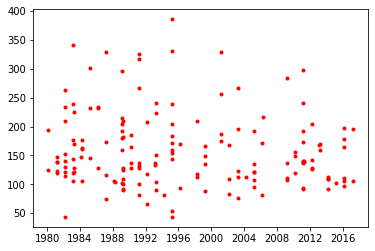

In [4]:
fig, ax = plt.subplots()
plt.plot_date(ds_merra.time, ivt_total, marker='.', color='red')

In [5]:
ivt_avg = np.nanmean(ivt_total)
ivt_avg

158.55202411278432

In [6]:
## timestep for plots 
m = 6

## Latitude and longitude of Santa Barbara
SB_lat = 34.5
SB_lon = -119.5+360

# ## location of maxiumum lightning strikes between 4 and 5 UTC 6 March 2019
# SB_lat = 34.0
# SB_lon = -120.0+360.0

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=SB_lat, longitude=SB_lon)

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 0.00

xarray.Dataset {
dimensions:
	time = 9 ;

variables:
	float64 latitude() ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	float64 longitude() ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	datetime64[ns] time(time) ;
		time:long_name = verification time generated by wgrib2 function verftime() ;
		time:reference_time_type = 1 ;
		time:reference_time_description = analyses, reference date is fixed ;
		time:time_step_setting = auto ;
		time:time_step = 0.0 ;
	float32 PRES_meansealevel(time) ;
		PRES_meansealevel:short_name = PRES_meansealevel ;
		PRES_meansealevel:long_name = Pressure ;
		PRES_meansealevel:level = mean sea level ;
		PRES_meansealevel:units = Pa ;
	float32 HGT_1mb(time) ;
		HGT_1mb:short_name = HGT_1mb ;
		HGT_1mb:long_name = Geopotential Height ;
		HGT_1mb:level = 1 mb ;
		HGT_1mb:units = m ;
	float32 TMP_1mb(time) ;
		TMP_1mb:short_name = TMP_1mb ;
		TMP_1mb:long_name = Temperature ;
		TMP_1mb:level = 

In [7]:
## Load the variables I want. Since I converted grib files to netCDF, 
## each vertical level is its own variable, so I stack them to create a single array
zero_isotherm = ds.HGT_0Cisotherm.load()
da_MSL = ds.PRES_meansealevel.load()
da_MSL = da_MSL/100 # convert to hPa

da_CAPE = ds.CAPE_surface.load()
da_CIN = ds.CIN_surface.load()

pressure = np.array([1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 
                     700, 650, 600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 100])

da_SPFH = np.stack([ds.SPFH_1000mb, ds.SPFH_975mb, ds.SPFH_950mb,
                 ds.SPFH_925mb, ds.SPFH_900mb, ds.SPFH_875mb,
                 ds.SPFH_850mb, ds.SPFH_825mb, ds.SPFH_800mb,
                 ds.SPFH_775mb, ds.SPFH_750mb, ds.SPFH_700mb,
                 ds.SPFH_650mb, ds.SPFH_600mb, ds.SPFH_550mb,
                 ds.SPFH_500mb, ds.SPFH_450mb, ds.SPFH_400mb,
                 ds.SPFH_350mb, ds.SPFH_300mb, ds.SPFH_250mb,
                 ds.SPFH_225mb, ds.SPFH_200mb, ds.SPFH_175mb,
                 ds.SPFH_150mb, ds.SPFH_100mb])

da_V = np.stack([ds.VGRD_1000mb, ds.VGRD_975mb, ds.VGRD_950mb,
                 ds.VGRD_925mb, ds.VGRD_900mb, ds.VGRD_875mb,
                 ds.VGRD_850mb, ds.VGRD_825mb, ds.VGRD_800mb,
                 ds.VGRD_775mb, ds.VGRD_750mb, ds.VGRD_700mb,
                 ds.VGRD_650mb, ds.VGRD_600mb, ds.VGRD_550mb,
                 ds.VGRD_500mb, ds.VGRD_450mb, ds.VGRD_400mb,
                 ds.VGRD_350mb, ds.VGRD_300mb, ds.VGRD_250mb,
                 ds.VGRD_225mb, ds.VGRD_200mb, ds.VGRD_175mb,
                 ds.VGRD_150mb, ds.VGRD_100mb])


da_V_knots = da_V * 1.94384 ## convert to knots


da_U = np.stack([ds.UGRD_1000mb, ds.UGRD_975mb, ds.UGRD_950mb,
                 ds.UGRD_925mb, ds.UGRD_900mb, ds.UGRD_875mb,
                 ds.UGRD_850mb, ds.UGRD_825mb, ds.UGRD_800mb,
                 ds.UGRD_775mb, ds.UGRD_750mb, ds.UGRD_700mb,
                 ds.UGRD_650mb, ds.UGRD_600mb, ds.UGRD_550mb,
                 ds.UGRD_500mb, ds.UGRD_450mb, ds.UGRD_400mb,
                 ds.UGRD_350mb, ds.UGRD_300mb, ds.UGRD_250mb,
                 ds.UGRD_225mb, ds.UGRD_200mb, ds.UGRD_175mb,
                 ds.UGRD_150mb, ds.UGRD_100mb])
da_U_knots = da_U * 1.94384 ## convert to knots

da_TMP = np.stack([ds.TMP_1000mb, ds.TMP_975mb, ds.TMP_950mb,
                 ds.TMP_925mb, ds.TMP_900mb, ds.TMP_875mb,
                 ds.TMP_850mb, ds.TMP_825mb, ds.TMP_800mb,
                 ds.TMP_775mb, ds.TMP_750mb, ds.TMP_700mb,
                 ds.TMP_650mb, ds.TMP_600mb, ds.TMP_550mb,
                 ds.TMP_500mb, ds.TMP_450mb, ds.TMP_400mb,
                 ds.TMP_350mb, ds.TMP_300mb, ds.TMP_250mb,
                 ds.TMP_225mb, ds.TMP_200mb, ds.TMP_175mb,
                 ds.TMP_150mb, ds.TMP_100mb])
da_TMP = da_TMP - 273.15 ## convert to degrees Celsius

da_RH = np.stack([ds.RH_1000mb.load(), ds.RH_975mb.load(), ds.RH_950mb.load(),
                 ds.RH_925mb.load(), ds.RH_900mb.load(), ds.RH_875mb.load(),
                 ds.RH_850mb.load(), ds.RH_825mb.load(), ds.RH_800mb.load(),
                 ds.RH_775mb.load(), ds.RH_750mb.load(), ds.RH_700mb.load(),
                 ds.RH_650mb.load(), ds.RH_600mb.load(), ds.RH_550mb.load(),
                 ds.RH_500mb.load(), ds.RH_450mb.load(), ds.RH_400mb.load(),
                 ds.RH_350mb.load(), ds.RH_300mb.load(), ds.RH_250mb.load(),
                 ds.RH_225mb.load(), ds.RH_200mb.load(), ds.RH_175mb.load(),
                 ds.RH_150mb.load(), ds.RH_100mb.load()])

da_GPH = np.stack([ds.HGT_1000mb.load(), ds.HGT_975mb.load(), ds.HGT_950mb.load(),
                 ds.HGT_925mb.load(), ds.HGT_900mb.load(), ds.HGT_875mb.load(),
                 ds.HGT_850mb.load(), ds.HGT_825mb.load(), ds.HGT_800mb.load(),
                 ds.HGT_775mb.load(), ds.HGT_750mb.load(), ds.HGT_700mb.load(),
                 ds.HGT_650mb.load(), ds.HGT_600mb.load(), ds.HGT_550mb.load(),
                 ds.HGT_500mb.load(), ds.HGT_450mb.load(), ds.HGT_400mb.load(),
                 ds.HGT_350mb.load(), ds.HGT_300mb.load(), ds.HGT_250mb.load(),
                 ds.HGT_225mb.load(), ds.HGT_200mb.load(), ds.HGT_175mb.load(),
                 ds.HGT_150mb.load(), ds.HGT_100mb.load()])

da_precip_rate = ds.PRATE_surface.load()*3600 ## converts units to mm/hour

In [8]:
## For use with:
# filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
# zero_isotherm = ds.hgt_0Cisotherm
# da_MSL = ds.prmsl
# da_MSL = da_MSL/100 # convert to hPa

# da_CAPE = ds.capesfc
# da_CIN = ds.cinsfc

# pressure = ds.p.values

# da_SPFH = ds.spfh

# da_V = ds.v
# da_V_knots = ds.v * 1.94384 ## convert to knots
# da_U = ds.u
# da_U_knots = ds.u * 1.94384 ## convert to knots

# da_TMP = ds.temp - 273.15 ## convert to degrees Celsius
# da_GPH = ds.hgtprs
# da_RH = ds.rh

# da_precip_rate = ds.prate *3600 ## converts units to mm/hour

### Calculations for Figure 3a - skew t ln p plot

In [9]:
## Calculate the dewpoint from relative humidity and temperature
RH = da_RH
T = da_TMP

td = 243.5*(np.log(RH/100)+((17.67*T)/(243.5+T)))/(17.67-np.log(RH/100)-((17.67*T)/(243.5+T)))
td = td[:,m] * units.degC
T = T[:,m] * units.degC
p = pressure * units.hPa
u = da_U_knots[:,m] * units.knots
v = da_V_knots[:,m] * units.knots

### Calculations for Figure 3b - vertical water vapor flux

In [10]:
## Calculate water vapor flux at each level (m/s)
wvf_u = da_U[:-6,m]*da_SPFH[:-6,m]
wvf_v = da_V[:-6,m]*da_SPFH[:-6,m]

wvf = np.sqrt(wvf_u**2 + wvf_v**2)
wvf.shape
# wind_speed = np.sqrt(da_U**2 + da_V**2)

## Interpolate wvf to smooth curve for plotting
X = np.flip(pressure[:-6])
power = np.flip(wvf)

xnew = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline(X, power, k=3) #BSpline object
power_smooth = spl(xnew)

### Calculations for Figure 3c - Wind and Temperature Vertical Profiles

In [11]:
## Create a dataframe with geopotential height, v, and u so that we can assign height values to the each pressure level
d = {'u': da_U_knots[:,0], 'v': da_V_knots[:,0], 
     'hgt': da_GPH[:,0], 'temp': da_TMP[:,0],
     'time':ds.time[0].values, 
     'time_idx':0}
df = pd.DataFrame(data=d)
df
for i in np.arange(1,9,1):
    df = df.append(pd.DataFrame({'u': da_U_knots[:,i], 'v': da_V_knots[:,i], 
                                 'hgt': da_GPH[:,i], 'temp': da_TMP[:,i],
                                 'time':ds.time[i].values, 
                                 'time_idx': i}))
    
    
df_pivot_v = df.pivot(index='hgt', columns='time_idx', values='v')
df_pivot_u = df.pivot(index='hgt', columns='time_idx', values='u')
df_pivot_tmp = df.pivot(index='hgt', columns='time_idx', values='temp')

## Only want to look below 5 km
u2 = df_pivot_u.values[:133,:]
v2 = df_pivot_v.values[:133,:]
y2 = df_pivot_v.index.values[:133]
magnitude = np.sqrt(u**2+v**2)
tmp = df_pivot_tmp.values[:133,:]

# ## Looking at all levels
# u2 = df_pivot_u.values
# v2 = df_pivot_v.values
# y = df_pivot_v.index.values
# magnitude = np.sqrt(u**2+v**2)

In [12]:
## Temperature Color Palette

clevs = [-29, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tmp_clevs = [(x - 32) * 5.0/9.0 for x in clevs]

# newList = [x / myInt for x in myList]

cmap_data = [(226., 224., 234.),
             (212., 151., 252.),
             (166., 0., 252.),
             (112., 0., 205.),
             (54., 47., 205.),
             (0., 156., 254.),
             (0., 207., 206.),
             (0., 178., 93.),
             (112., 255., 116.),
             (255., 255., 31.),
             (255., 192., 0.),
             (255., 150., 27.),
             (255., 91., 0.),
             (255., 0., 0.),
             (229., 0., 98.)]
# cmap_data
myInt = 255.0
newCmap = []
for i in np.arange(len(cmap_data)):
    newCmap.append([x / myInt for x in cmap_data[i]])
tmp_cmap = mcolors.ListedColormap(newCmap, 'tmp')
tmp_norm = mcolors.BoundaryNorm(tmp_clevs, tmp_cmap.N)


### Plot Fig 3

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


./figures/f3.png


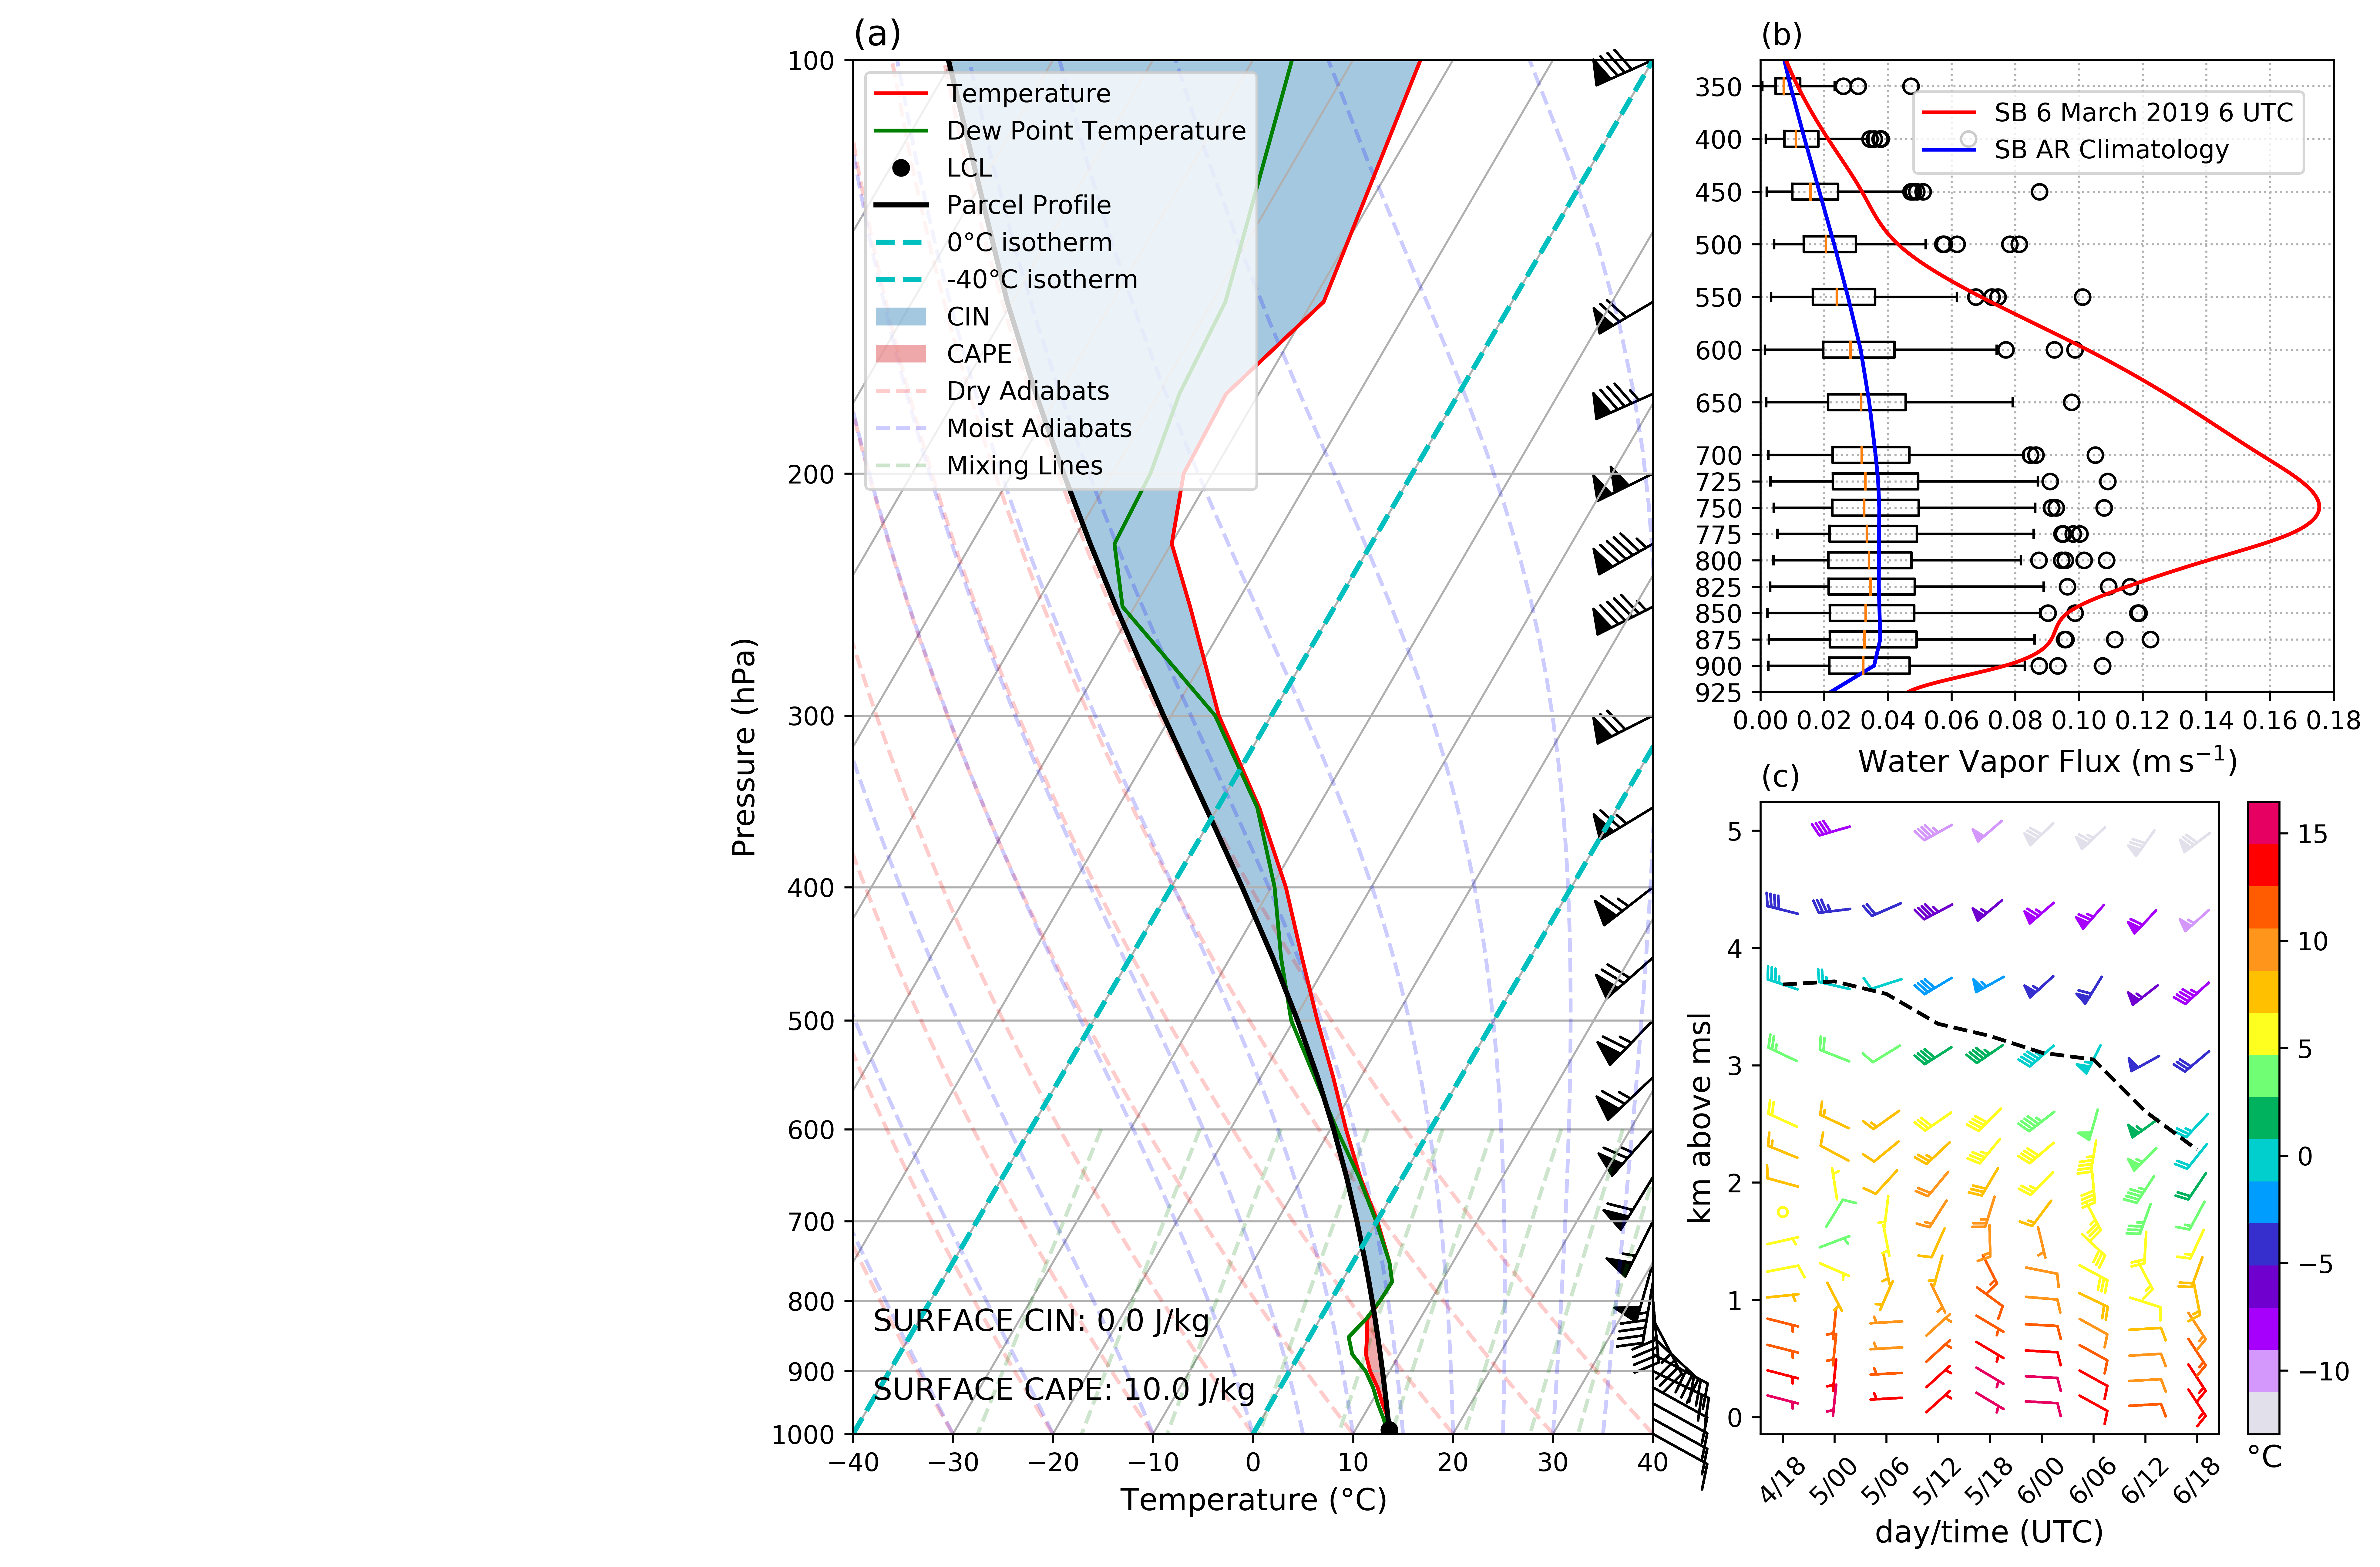

<Figure size 6300x6000 with 0 Axes>

In [15]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(10.5,10.0))
fig.dpi = 600
fname = './figures/f3'
fmt1 = 'png'
fmt2 = 'pdf'

numrows = 6
numcols = 7
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = gridspec.GridSpec(numrows, numcols)

## [rows index, columns index]

######################################################
# Plot for Figure 3a - vertical sounding (skewt-lnp) #
######################################################

# ax1 = plt.subplot(gs[:, :2])
skew = SkewT(fig, rotation=45, subplot=gs[:, :4])

skew.plot(p, T, 'r', label='Temperature')
skew.plot(p, td, 'g', label='Dew Point Temperature')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', label='LCL')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Parcel Profile')

plt.xlabel('Temperature ($\mathrm{\degree C}$)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)
# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, label='CIN')
skew.shade_cape(p, T, prof, label='CAPE')

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2, label='0$\degree$C isotherm')
skew.ax.axvline(-40, color='c', linestyle='--', linewidth=2, label='-40$\degree$C isotherm')

# Add the relevant special lines
skew.plot_dry_adiabats(label='Dry Adiabats', alpha=0.2)
skew.plot_moist_adiabats(label='Moist Adiabats', alpha=0.2)
skew.plot_mixing_lines(label='Mixing Lines', alpha=0.2)
## Add legend
plt.legend(loc='upper left')

## Add CAPE and CIN values as text
plt.text(0.025, 0.025, 'SURFACE CAPE: '+"{:.1f}".format(da_CAPE[m].values.item())+' '+da_CAPE[m].units,
         transform=skew.ax.transAxes, fontsize=12)
plt.text(0.025, 0.075, 'SURFACE CIN: '+"{:.1f}".format(da_CIN[m].values.item())+' '+da_CIN[m].units,
         transform=skew.ax.transAxes, fontsize=12)

plt.title('(a)', fontsize=14, loc='left')

######################################
# Plot Fig3b - for water vapor flux  #
######################################

ax3 = plt.subplot(gs[:3, 4:7]) 

x_levels = np.arange(0.0, 0.2, 0.02)
y_levels = np.array([900, 800, 800, 700, 600, 500, 400, 300])

ax3.boxplot(data_plot, vert=False, widths=15.0, positions=MERRA_flux.lev.values)

clim = ax3.plot(merra_mean, MERRA_flux.lev.values, 'b-', label='SB AR Climatology')
event = ax3.plot(power_smooth, xnew, 'r-', label='SB 6 March 2019 6 UTC')
plt.gca().invert_yaxis()

ax3.set_ylim([925, 325])
ax3.set_xlim([0,0.18])
ax3.set_xticks(x_levels)
# ax3.set_yticks(y_levels)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%g'))



# ax3.set_ylabel('Pressure (hPa)', fontsize=12)
ax3.set_xlabel('Water Vapor Flux ($\mathrm{m \: s^{-1}}$)', fontsize=12)
ax3.grid(linestyle=':')

plt.title('(b)', fontsize=12, loc='left')

## add legend
lns = event+clim
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='upper right', bbox_to_anchor=(0.97, 0.97))

####################################################
# Plot Fig3c - vertical wind/temperature with time #
####################################################

ax2 = plt.subplot(gs[3:, 4:7])

ax2.plot(np.arange(9), zero_isotherm/1000.0, 'k--')

Q = plt.barbs(np.arange(9), y2/1000.0, u2, v2, tmp, pivot='middle',
             cmap=tmp_cmap, length=5)

cbar = fig.colorbar(Q, ax=ax2, extend='neither', norm=tmp_norm)
# cbar.set_label('$\degree C$', labelpad=-40, y=1.05, rotation=0, fontsize=12)

cbar.ax.set_xlabel('$\mathrm{\degree C}$', fontsize=12)

plt.ylabel('km above msl', fontsize=12)
plt.xlabel('day/time (UTC)', fontsize=12)

# ax2_divider = make_axes_locatable(ax2)
# # add an axes above the main axes.
# cax2 = ax2_divider.append_axes("top", size="7%", pad="2%")
# cb2 = colorbar(Q, cax=cax2, orientation="horizontal", extend='neither', norm=tmp_norm)
# # change tick position to top. Tick position defaults to bottom and overlaps
# # the image.
# cax2.xaxis.set_ticks_position("top")

xticklabels = ['4/18', '5/00', '5/06', '5/12', '5/18',
            '6/00', '6/06', '6/12', '6/18']

# locs, labels = xticks()            # Get locations and labels
plt.xticks(np.arange(9), xticklabels)  # Set locations and labels
ax2.xaxis.set_tick_params(rotation=45, labelsize=10)

plt.title('(c)', fontsize=12, loc='left')

### Finalize Figure ### 
gs.update(hspace=0.8, wspace=0.9)
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))